# VQC - DGA Botnet detection

Madjid Tehrani
Cybersec-DMS (DMS GmbH)
#https://www.cybersec-dms.com/
Copyright © 2023, DMS GmbH. All rights reserved. Permission is hereby granted, free of charge, to any person obtaining a copy of this
software and associated documentation files (the "Software"), for academic research purposes, subject to the following conditions:
the above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.   


In [ ]:
!pip install -U azure-quantum
!pip install -U azure-quantum[qiskit]
!pip install -U qiskit_machine_learning
!pip install pylatexenc
!pip install qiskit --upgrade;
!pip install qiskit-aer;
!pip install qiskit-terra;
!pip install qiskit-machine-learning;

In [ ]:
import qiskit
print(qiskit.__version__)

0.25.0


In [ ]:
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor
from azure.quantum.qiskit import AzureQuantumProvider
from qiskit import QuantumCircuit, execute, Aer
from qiskit import *
from qiskit.utils import QuantumInstance
from azure.quantum import Workspace

provider = AzureQuantumProvider (
    resource_id = "/subscriptions/YourID/resourceGroups/AzureQuantum/providers/Microsoft.Quantum/Workspaces/YourWorkspace",
    location = "eastus"
)

print("This workspace's targets:")
for backend in provider.backends():
    print("- " + backend.name())

workspace = Workspace (
    subscription_id = "YourID",
    resource_group = "AzureQuantum",
    name = "YourWorkspace",
    location = "eastus"

)



# Create IonQ simulator and QPU backends
ionq_simulator_backend = provider.get_backend("ionq.simulator")
ionq_qpu_backend = provider.get_backend("ionq.qpu")

# Create Rigetti simulator and QPU backends
rigetti_simulator_backend = provider.get_backend("rigetti.sim.qvm")
rigetti_qpu_backend = provider.get_backend("rigetti.qpu.aspen-m-3")

# Create Quantinuum simulator and QPU backends
Quantinuum_simulator_backend = provider.get_backend("quantinuum.sim.h1-2sc")
Quantinuum_qpu_backend = provider.get_backend("quantinuum.qpu.h1-2")

# Create QASM simulator
backend = Aer.get_backend('qasm_simulator')

In [ ]:
#Function to load a file from a publicly accessible URL
import urllib.request

def download_file(url, save_path):
    urllib.request.urlretrieve(url, save_path)
    print(f'File successfully downloaded to {save_path}.')

In [ ]:
#vqc
from qiskit import transpile, BasicAer, QuantumCircuit
backend = BasicAer.get_backend("qasm_simulator")
#backend = rigetti_simulator_backend
#backend = ionq_simulator_backend
#backend  = Quantinuum_simulator_backend

In [ ]:
print(backend)

qasm_simulator


In [ ]:
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap, ZFeatureMap
from qiskit.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit.algorithms.optimizers import SLSQP, SPSA
from qiskit.circuit.library import TwoLocal
from qiskit import Aer, transpile

import numpy as np
import matplotlib.pyplot as plt
import datetime
import concurrent.futures
import time
import os
import csv
import pandas as pd
from IPython.display import clear_output

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Binarizer
from sklearn.decomposition import PCA


n_features = 7
training_size = 700
test_size = 300
feature_dim = 7
num_samples = 1000
datafilename="BotnetDgaDataset_1000.csv"
resultname="result_BotnetDgaDataset_1000.txt"
cwd=os.getcwd()
mycsv=cwd+"/"+datafilename

download_file('https://aq5efd7d2644dd406cb3ec2d.blob.core.windows.net/dga/BotnetDgaDataset_1000.csv', mycsv)

def load_data(filepath):

    with open(filepath) as csv_file:
        data_file = csv.reader(csv_file)
        temp = next(data_file)
        n_samples = 1000
        n_features = 7
        target_names = np.array(temp[2:])
        data = np.empty((n_samples, n_features))
        target = np.empty((n_samples,), dtype=np.int)

        for i, ir in enumerate(data_file):
            data[i] = np.asarray(ir[:-1], dtype=np.float64)
            target[i] = np.asarray(ir[-1], dtype=np.int)

    return data, target, target_names

File successfully downloaded to /content/BotnetDgaDataset_1000.csv.


In [ ]:
#this code is from https://ieee-dataport.org/open-access/botnet-dga-dataset
def _convert_data_dataframe(data, target,
                            feature_names, target_names):
    data_df = pd.DataFrame(data, columns=feature_names)
    target_df = pd.DataFrame(target, columns=target_names)
    combined_df = pd.concat([data_df, target_df], axis=1)
    X = combined_df[feature_names]
    y = combined_df[target_names]
    if y.shape[1] == 1:
        y = y.iloc[:, 0]
    return combined_df, X, y


def load_botnetdga(*, as_frame=False):

    data, target, target_names = load_data('BotnetDgaDataset_1000.csv')



    feature_names = ['MinREBotnets',
                     'CharLength',
                     'TreeNewFeature',
                     'nGramReputation_Alexa']

    frame = None
    target_columns = ['target', ]
    if as_frame:
        frame, data, target = _convert_data_dataframe(data,
                                                      target,
                                                      feature_names,
                                                      target_columns)

    return data, target


def botnetdga(training_size, test_size, n,
              standardize=False, pca=False, scale=False, plot_data=False,
              binarize=False):

    class_labels = [r'benign', r'dga']

    data, target = load_botnetdga()
    sample_train, sample_test, label_train, label_test = \
        train_test_split(data, target, train_size=training_size, test_size=test_size, random_state=7)

    # print("\n load_botnetdga sample_train = \n")
    # print(sample_train)
    # print("\n load_botnetdga sample_test = \n")
    # print(sample_test)

    # Now we standardize for gaussian around 0 with unit variance
    if standardize:
        std_scale = StandardScaler().fit(sample_train)
        sample_train = std_scale.transform(sample_train)
        sample_test = std_scale.transform(sample_test)

        # print("\n standardize sample_train = \n")
        # print(sample_train)
        # print("\n standardize sample_test = \n")
        # print(sample_test)

    # Now reduce number of features to number of qubits
    if pca:
        pca = PCA(n_components=n).fit(sample_train)
        sample_train = pca.transform(sample_train)
        sample_test = pca.transform(sample_test)

        # print("\n pca sample_train = \n")
        # print(sample_train)
        # print("\n pca sample_test = \n")
        # print(sample_test)

    # Scale to the range (-1,+1)
    if scale:
        samples = np.append(sample_train, sample_test, axis=0)
        minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
        sample_train = minmax_scale.transform(sample_train)
        sample_test = minmax_scale.transform(sample_test)

        # print("\n scale sample_train = \n")
        # print(sample_train)
        # print("\n scale sample_test = \n")
        # print(sample_test)

    if binarize:
        med = np.median(np.append(sample_train, sample_test, axis=0), axis=0)

        # print("\n binarize np.append(sample_train, sample_test, axis=0) = \n")
        # print(np.append(sample_train, sample_test, axis=0)[:5])
        # print("\n binarize med = \n")
        # print(med)

        transformer = Binarizer(threshold=med)
        # print("\n binarize transformer = \n")
        # print(transformer)

        sample_train = transformer.transform(sample_train)
        sample_test = transformer.transform(sample_test)

        # print("\n binarize sample_train = \n")
        # print(sample_train)
        # print("\n binarize sample_test = \n")
        # print(sample_test)

    # Pick training size number of samples from each distro
    training_input = {key: (sample_train[label_train == k, :])[:training_size]
                      for k, key in enumerate(class_labels)}
    test_input = {key: (sample_test[label_test == k, :])[:test_size]
                  for k, key in enumerate(class_labels)}

    return sample_train, training_input, test_input, class_labels

In [ ]:
#import time
start = time.perf_counter()

# BotnetDGA data set
plot_data = False
training_size = 700
test_size = 300
feature_dim = 7
standardize = False
pca = False
scale = False
binarize = False



# random_seed = 10598
# shots = 1024
# seed = 1376
# aqua_globals.random_seed = seed

sample_train, training_input, test_input, class_labels = botnetdga(training_size=training_size,
                                                                    test_size=test_size,
                                                                    n=feature_dim,
                                                                    standardize=standardize,
                                                                    pca=pca,
                                                                    scale=scale,
                                                                    plot_data=plot_data,
                                                                    binarize=binarize)

# print("\n sample_train = \n")
# print(sample_train)
# print("\n training_input = \n")
# print(training_input)
# print("\n test_input = \n")
# print(test_input)
# print("\n class_labels = \n")
# print(class_labels)

optimizer1 = SPSA()
#optimizer2 = ADAM()
#optimizer3 = AQGD()
#optimizer4 = CG()
#optimizer5 = COBYLA()
#optimizer6 = L_BFGS_B()
#optimizer7 = GSLS()
#optimizer8 = NELDER_MEAD()
#optimizer9 = NFT()
#optimizer10 = P_BFGS()
#optimizer11 = POWELL()
#optimizer12 = SLSQP()
#optimizer13 = TNC()

nFeature = 7

#feature_map1 = RawFeatureVector(nFeature)
#feature_map2 = PauliFeatureMap(nFeature)
feature_map3 = ZFeatureMap(nFeature)
#feature_map4 = ZZFeatureMap(nFeature)

#var_form11 = TwoLocal(feature_map1.num_qubits, ['ry', 'rz'], 'cz')
#var_form12 = RealAmplitudes(feature_map1.num_qubits)
#var_form13 = EfficientSU2(feature_map1.num_qubits)
#var_form14 = ExcitationPreserving(feature_map1.num_qubits)

#var_form21 = TwoLocal(feature_map2.num_qubits, ['ry', 'rz'], 'cz')
#var_form22 = RealAmplitudes(feature_map2.num_qubits)
#var_form23 = EfficientSU2(feature_map2.num_qubits)
#var_form24 = ExcitationPreserving(feature_map2.num_qubits)

#var_form31 = TwoLocal(feature_map3.num_qubits, ['ry', 'rz'], 'cz')
var_form32 = RealAmplitudes(feature_map3.num_qubits)
#var_form33 = EfficientSU2(feature_map3.num_qubits)
#var_form34 = ExcitationPreserving(feature_map3.num_qubits)

#var_form41 = TwoLocal(feature_map4.num_qubits, ['ry', 'rz'], 'cz')
#var_form42 = RealAmplitudes(feature_map4.num_qubits)
#var_form43 = EfficientSU2(feature_map4.num_qubits)
#var_form44 = ExcitationPreserving(feature_map4.num_qubits)

In [ ]:
import numpy as np
points_train = np.concatenate([training_input['benign'], training_input['dga']])
labels_train = np.concatenate([np.ones(len(training_input['benign'])), -np.ones(len(training_input['dga']))])
points_test = np.concatenate([test_input['benign'], test_input['dga']])
labels_test = np.concatenate([np.ones(len(test_input['benign'])), -np.ones(len(test_input['dga']))])

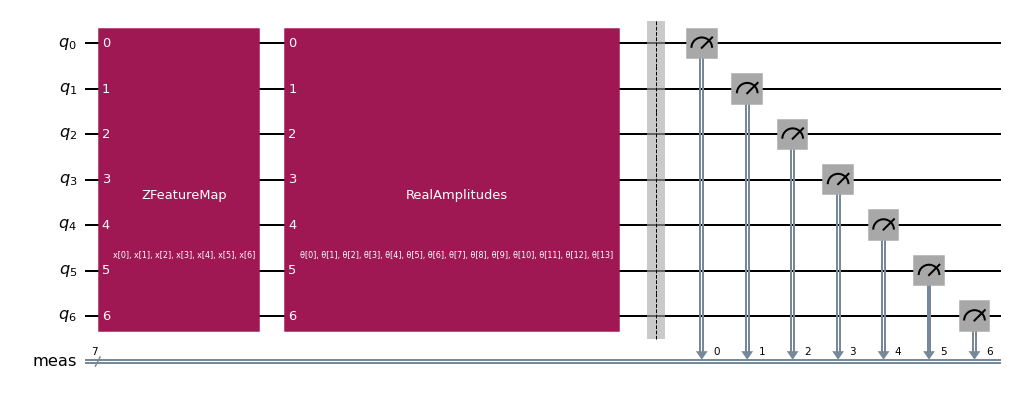

In [ ]:
from qiskit.circuit.library import RealAmplitudes, ZFeatureMap, ZZFeatureMap, EfficientSU2

num_features =7
feature_map=ZFeatureMap(num_features,reps=1)
model=RealAmplitudes(num_features, reps=1, entanglement="pairwise")
circuit=feature_map.compose(model)
circuit.measure_all()
circuit.draw("mpl",style="iqx")

In [ ]:
from qiskit_machine_learning.algorithms import VQC
vqc = VQC(num_features,
          feature_map=feature_map,
          ansatz=model,
          loss="cross_entropy",
          optimizer=COBYLA(),
          quantum_instance=backend)
vqc.fit(points_train,labels_train)
vqc_predictions=vqc.predict(points_test)

In [ ]:
vqc.score(points_test,labels_test)
#vqc.save()

0.6333333333333333

In [ ]:
vqc.score(points_train,labels_train)

0.6057142857142858

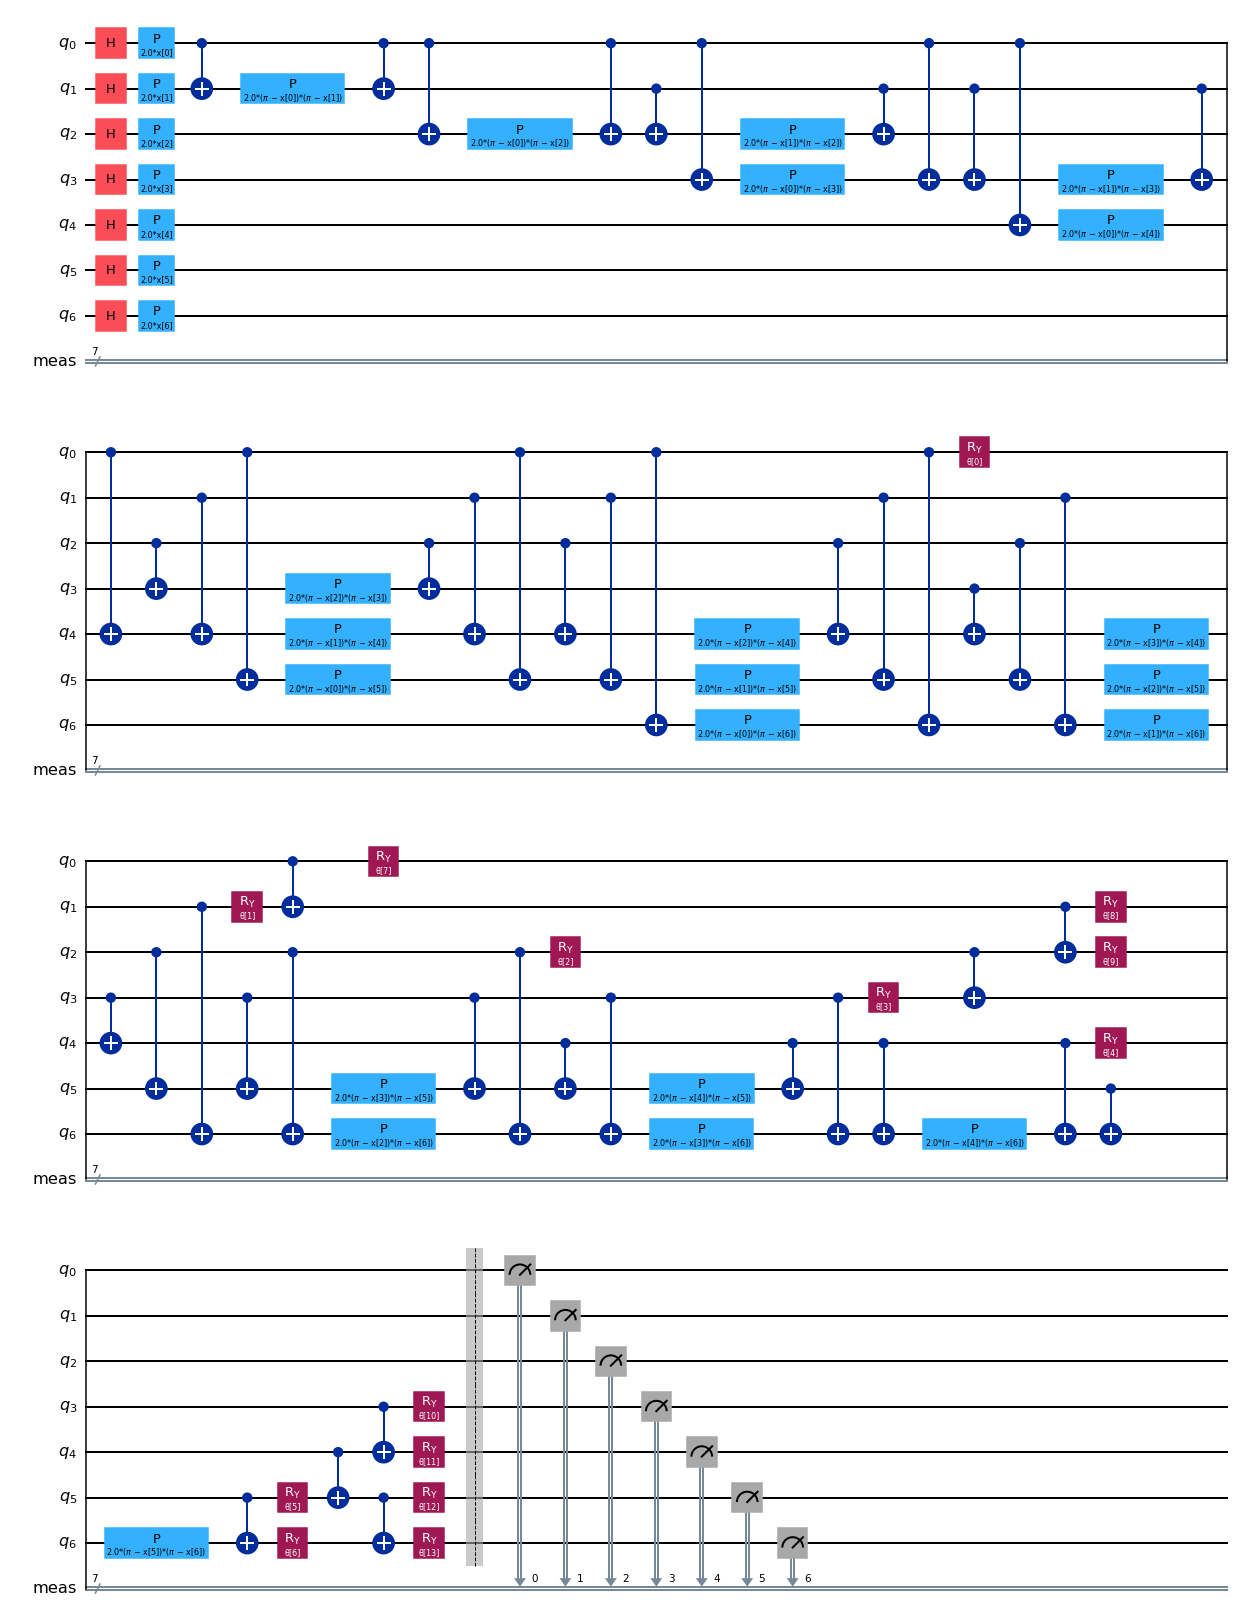

In [ ]:
circuit.decompose().draw("mpl", style="iqx")

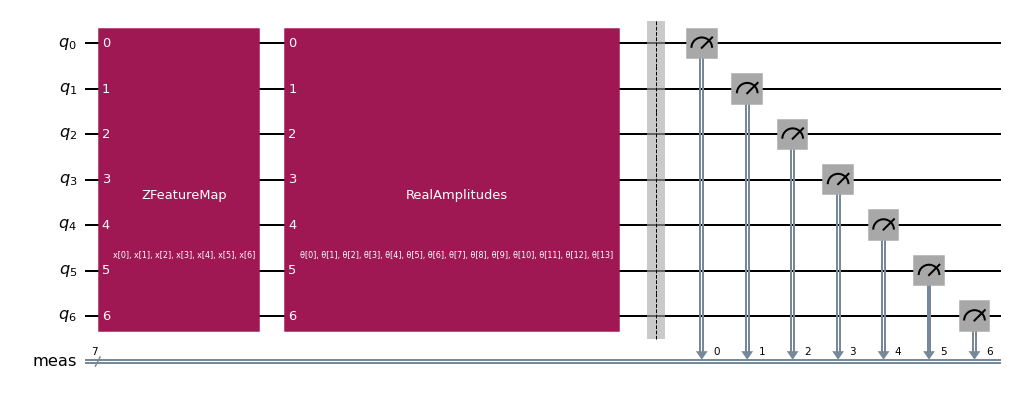

In [ ]:
#backend=rigetti_simulator_backend
backend = Aer.get_backend('qasm_simulator')
from qiskit.circuit.library import RealAmplitudes, ZFeatureMap, ZZFeatureMap, EfficientSU2

num_features =7
feature_map=ZFeatureMap(num_features,reps=1)
model=RealAmplitudes(num_features, reps=1, entanglement="pairwise")
circuit=feature_map.compose(model)
circuit.measure_all()
circuit.draw("mpl",style="iqx")

In [ ]:
from pickle import TRUE
from qiskit.circuit.library import RealAmplitudes, ZFeatureMap, ZZFeatureMap, EfficientSU2
from qiskit.result.mitigation.utils import counts_probability_vector
from qiskit.algorithms.optimizers import COBYLA
from qiskit.result import counts
import time
cutoff=1e-10
shots=1024
start = time.perf_counter()

transpiled=transpile(circuit,backend)
#parity calculation function
def parity(bitstring):
  #return 1 if there's an even number of 1's , otherwise return -1
  return 1 if bitstring.count("1") %2 else -1
predic_Call_count = 0
#prediction needed for calculation theta and also prediction-called by loss()
def predict(theta, point, return_probabilities=False):
  global predic_Call_count
  predic_Call_count += 1
  print("predic_Call_count=",predic_Call_count)
  #feeding theta to circuit
  bound = transpiled.assign_parameters(np.concatenate((point, theta)))
  #exception handling of quantum device failure
  while True:
    try:
      job=backend.run(bound, shots=shots)
      #print("jobID=",job.id())
      result=job.result()
      counts=result.get_counts()
      pr_1=0
      for bitstr , count in counts.items():
        if parity(bitstr)==1:
          pr_1+=count/shots
      if return_probabilities:
        return pr_1
      return 1 if pr_1>0.5 else 0
      #f.write("   jobID = " + str(job.id())+ "  result = " + str(pr_1)+ "\n\n")

    except Exception as e:
      print(f"Error: {str(e)}. Skipping job.")
      continue  # Skip to the next job if there's an error
#safe logarithm function
def safe_log(value):
  return np.log(max(cutoff,value))
#cross-entropy loss function
def loss(theta, X, y):
  loss_value=0
  loss_call_count = getattr(loss, 'call_count', 0) + 1
  setattr(loss, 'call_count', loss_call_count)
  print(f"Call_Loss_implies_to_call_predict {loss_call_count}:")
  for X_i, y_i in zip(X,y):
    pr_1=predict(theta, X_i,return_probabilities=True)
    loss_value -=y_i*safe_log(pr_1)+(1-y_i)*safe_log(1-pr_1)
  return loss_value
#theta calculation
one_zero_labels=(1+np.array(labels_train))/2
cost=lambda theta: loss(theta, points_train, one_zero_labels.tolist())
#optimization
x0=np.random.random(model.num_parameters)
cobyla = COBYLA()
result_theta = cobyla.minimize(cost, x0=x0)


Streaming output truncated to the last 5000 lines.
predic_Call_count= 90208
predic_Call_count= 90209
predic_Call_count= 90210
predic_Call_count= 90211
predic_Call_count= 90212
predic_Call_count= 90213
predic_Call_count= 90214
predic_Call_count= 90215
predic_Call_count= 90216
predic_Call_count= 90217
predic_Call_count= 90218
predic_Call_count= 90219
predic_Call_count= 90220
predic_Call_count= 90221
predic_Call_count= 90222
predic_Call_count= 90223
predic_Call_count= 90224
predic_Call_count= 90225
predic_Call_count= 90226
predic_Call_count= 90227
predic_Call_count= 90228
predic_Call_count= 90229
predic_Call_count= 90230
predic_Call_count= 90231
predic_Call_count= 90232
predic_Call_count= 90233
predic_Call_count= 90234
predic_Call_count= 90235
predic_Call_count= 90236
predic_Call_count= 90237
predic_Call_count= 90238
predic_Call_count= 90239
predic_Call_count= 90240
predic_Call_count= 90241
predic_Call_count= 90242
predic_Call_count= 90243
predic_Call_count= 90244
predic_Call_count= 90245

In [ ]:
predictions = [predict(result_theta.x,X_i,return_probabilities=False) for X_i in points_train.tolist()]

predic_Call_count= 131601
predic_Call_count= 131602
predic_Call_count= 131603
predic_Call_count= 131604
predic_Call_count= 131605
predic_Call_count= 131606
predic_Call_count= 131607
predic_Call_count= 131608
predic_Call_count= 131609
predic_Call_count= 131610
predic_Call_count= 131611
predic_Call_count= 131612
predic_Call_count= 131613
predic_Call_count= 131614
predic_Call_count= 131615
predic_Call_count= 131616
predic_Call_count= 131617
predic_Call_count= 131618
predic_Call_count= 131619
predic_Call_count= 131620
predic_Call_count= 131621
predic_Call_count= 131622
predic_Call_count= 131623
predic_Call_count= 131624
predic_Call_count= 131625
predic_Call_count= 131626
predic_Call_count= 131627
predic_Call_count= 131628
predic_Call_count= 131629
predic_Call_count= 131630
predic_Call_count= 131631
predic_Call_count= 131632
predic_Call_count= 131633
predic_Call_count= 131634
predic_Call_count= 131635
predic_Call_count= 131636
predic_Call_count= 131637
predic_Call_count= 131638
predic_Call_

In [ ]:
correct_predictions = 0
for label, predicted_label in zip(one_zero_labels, predictions):
  if label == predicted_label:
    correct_predictions += 1

accuracy = correct_predictions / len(one_zero_labels)
print("Accuracy:", accuracy)


Accuracy: 0.6985714285714286
